In [13]:
import openturns as ot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from shapley import ShapleyIndices, ShapleyKrigingIndices, SobolIndices, SobolKrigingIndices
from shapley.tests import Ishigami, AdditiveGaussian
from shapley.tests.utils import true_gaussian_full_ind_sobol
from shapley.plots import set_style_paper, plot_sensitivity_results

%load_ext autoreload
%autoreload 2

%matplotlib inline

set_style_paper()

savefigs = False
ylim = [-0.05, 1.05]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
dim = 3
beta = None
model = AdditiveGaussian(dim=dim, beta=beta)

n_theta = 5
thetas = np.linspace(-0.99, 0.99, n_theta)

theta = [0., 0., thetas[1]]
model.copula_parameters = theta
true_full_indices, true_ind_indices = true_gaussian_full_ind_sobol(theta, dim=dim)

In [27]:
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

n_sample = 1000

# Evaluate the model
sobol = SobolIndices(model.input_distribution)
sobol.build_uncorrelated_mc_sample(model, n_sample)

In [28]:
n_boot = 500
estimator = 'sobolmara'
sobol_results_full = sobol.compute_full_indices(n_boot=n_boot, estimator=estimator)
sobol_results_ind = sobol.compute_ind_indices(n_boot=n_boot, estimator=estimator)

# Results
first_indices_full_mc = sobol_results_full.first_indices
total_indices_full_mc = sobol_results_full.total_indices
first_indices_ind_mc = sobol_results_ind.first_indices
total_indices_ind_mc = sobol_results_ind.total_indices

print("Full Sobol indices:", first_indices_full_mc)
print("Full Total Sobol indices:", first_indices_full_mc)
print("Ind Sobol indices:", first_indices_ind_mc)
print("Ind Total Sobol indices:", first_indices_ind_mc)

Full Sobol indices: [ 0.46137281  0.10838053  0.10633031]
Full Total Sobol indices: [ 0.46137281  0.10838053  0.10633031]
Ind Sobol indices: [ 0.51340032  0.3927304   0.4029347 ]
Ind Total Sobol indices: [ 0.51340032  0.3927304   0.4029347 ]


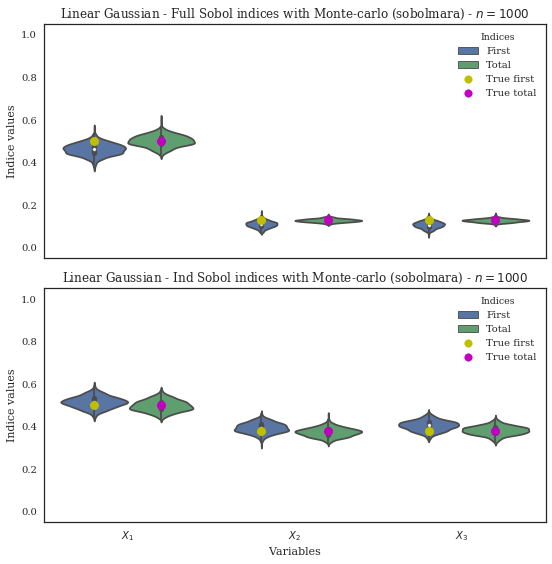

In [29]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(8, 8))
ax = axes[0]

sobol_results_full.true_first_indices = true_full_indices
sobol_results_full.true_total_indices = true_full_indices

plot_sensitivity_results(sobol_results_full, ax=ax)
ax.set_title("Linear Gaussian - Full Sobol indices with Monte-carlo (%s) - $n=%d$" % (estimator, n_sample))
ax.set_ylim(ylim)
ax.set_xlabel('')
    
ax = axes[1]
sobol_results_ind.true_first_indices = true_ind_indices
sobol_results_ind.true_total_indices = true_ind_indices

plot_sensitivity_results(sobol_results_ind, ax=ax)
ax.set_title("Linear Gaussian - Ind Sobol indices with Monte-carlo (%s) - $n=%d$" % (estimator, n_sample))
ax.set_ylim(ylim)
fig.tight_layout()
if savefigs:
    fig.savefig('./output/gaussian_dep_full_ind_theta_%d_n_%d_%s.pdf' % (id_theta, n_sample, estimator))